/var/folders/5g/dxyz07h551b0md8v8dx0w1w80000gn/T/ipykernel_49808/581566632.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_temp = pd.read_csv(berkeley_path, comment='%', delim_whitespace=True, header=None)


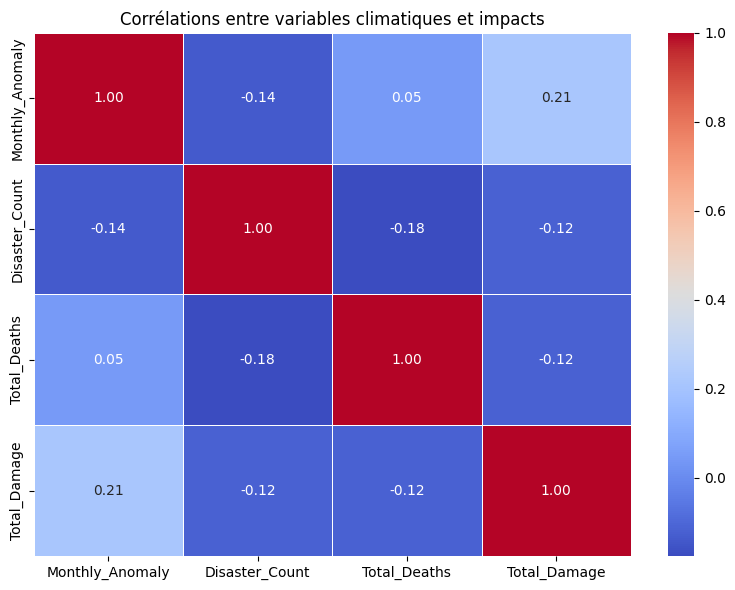

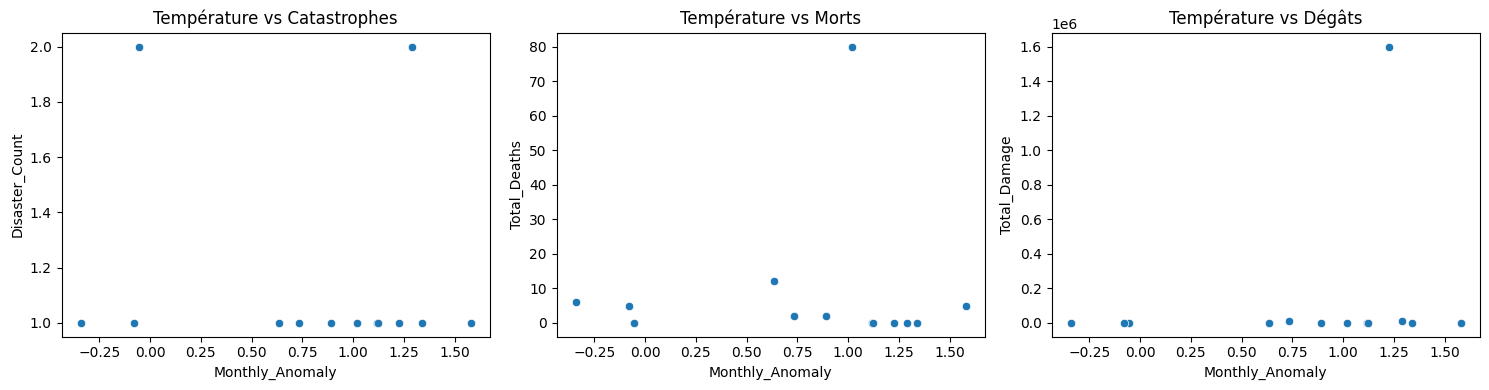

In [2]:
# -----------------------------
# PHASE 3 – TP3 CLIMAT - FRANCE
# Analyse comparative & mise en relation
# -----------------------------

# 📥 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# 📂 Chargement des fichiers
berkeley_path = "/Users/jeniferawounou/Desktop/france-(europe)-TAVG-Trend-bon.txt"
df_temp = pd.read_csv(berkeley_path, comment='%', delim_whitespace=True, header=None)

df_temp.columns = [
    "Year", "Month", "Monthly_Anomaly", "Monthly_Unc",
    "Annual_Anomaly", "Annual_Unc", "FiveYear_Anomaly", "FiveYear_Unc",
    "TenYear_Anomaly", "TenYear_Unc", "TwentyYear_Anomaly", "TwentyYear_Unc"
]
df_temp['Date'] = pd.to_datetime(dict(year=df_temp.Year, month=df_temp.Month, day=1))
emdat_path = "/Users/jeniferawounou/Desktop/public_emdat_custom_request_2025-04-01_955b1370-4c28-4320-97f2-9b207c3e884d.xlsx"

# Lecture du fichier Excel (après avoir installé openpyxl)
df_disasters = pd.read_excel("/Users/jeniferawounou/Desktop/public_emdat_custom_request_2025-04-01_955b1370-4c28-4320-97f2-9b207c3e884d.xlsx", engine="openpyxl")

df_disasters['Country'] = df_disasters['Country'].str.strip().str.lower()
df_france = df_disasters[df_disasters['Country'] == 'france']

# 📊 Agrégation des catastrophes par année
df_disasters_yearly = df_france.groupby('Start Year').agg({
    'Disaster Type': 'count',
    'Total Deaths': 'sum',
    "Total Damage ('000 US$)": 'sum'
}).reset_index()
df_disasters_yearly.columns = ['Year', 'Disaster_Count', 'Total_Deaths', 'Total_Damage']

# 🌡️ Moyenne annuelle des températures depuis 1900
df_temp_filtered = df_temp[df_temp['Year'] >= 1900]
df_temp_yearly = df_temp_filtered.groupby('Year').agg({
    'Monthly_Anomaly': 'mean'
}).reset_index()

# 🔁 Fusion des datasets
df_merged = pd.merge(df_temp_yearly, df_disasters_yearly, on='Year', how='inner')
df_clean = df_merged.dropna()

# -----------------------------
# 🔍 Étape 1 : Corrélations statistiques
# -----------------------------

correlations = df_clean[['Monthly_Anomaly', 'Disaster_Count', 'Total_Deaths', 'Total_Damage']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Corrélations entre variables climatiques et impacts")
plt.tight_layout()
plt.show()

# -----------------------------
# 📊 Étape 2 : Nuages de points (scatter plots)
# -----------------------------

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=df_clean, x='Monthly_Anomaly', y='Disaster_Count')
plt.title("Température vs Catastrophes")

plt.subplot(1, 3, 2)
sns.scatterplot(data=df_clean, x='Monthly_Anomaly', y='Total_Deaths')
plt.title("Température vs Morts")

plt.subplot(1, 3, 3)
sns.scatterplot(data=df_clean, x='Monthly_Anomaly', y='Total_Damage')
plt.title("Température vs Dégâts")

plt.tight_layout()
plt.show()

# -----------------------------
# 💾 (optionnel) Exporter le fichier fusionné avec analyse
# -----------------------------
df_clean.to_csv("donnees_fusionnees_phase3.csv", index=False)


In [2]:
!pip install seaborn



  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [3]:
import folium
from folium.plugins import MarkerCluster

# On récupère uniquement les catastrophes géolocalisées en France
df_geo = df_france[['Start Year', 'Disaster Type', 'Total Deaths', 'Latitude', 'Longitude']].dropna()

# Création de la carte centrée sur la France
map_france = folium.Map(location=[46.5, 2], zoom_start=5, tiles='CartoDB positron')

# Cluster pour regrouper les marqueurs
marker_cluster = MarkerCluster().add_to(map_france)

# Ajout des points de catastrophe
for _, row in df_geo.iterrows():
    popup_text = f"""
    📅 Année : {int(row['Start Year'])}<br>
    🌪️ Type : {row['Disaster Type']}<br>
    💀 Morts : {int(row['Total Deaths']) if not pd.isna(row['Total Deaths']) else 0}
    """
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_text, max_width=250),
        icon=folium.Icon(color="red", icon="exclamation-sign"),
    ).add_to(marker_cluster)

map_france
# On utilise Paris (48.8566, 2.3522) comme localisation moyenne pour illustrer les événements

# On repart du DataFrame des catastrophes en France avec agrégation par année
df_events = df_france.groupby('Start Year').agg({
    'Disaster Type': 'count',
    'Total Deaths': 'sum'
}).reset_index()

df_events.columns = ['Year', 'Event_Count', 'Total_Deaths']
df_events = df_events[df_events['Year'] >= 1949]  # Cohérence avec les températures

# Création de la carte centrée sur la France
map_illustrative = folium.Map(location=[48.8566, 2.3522], zoom_start=5, tiles='CartoDB positron')

# Ajout de cercles proportionnels au nombre de catastrophes
for _, row in df_events.iterrows():
    folium.CircleMarker(
        location=[48.8566, 2.3522],
        radius=row['Event_Count'] * 1.5,  # Échelle ajustable
        popup=f"Année : {int(row['Year'])}<br>Événements : {row['Event_Count']}<br>Morts : {int(row['Total_Deaths'])}",
        color='crimson',
        fill=True,
        fill_opacity=0.5
    ).add_to(map_illustrative)

map_illustrative

map_illustrative.save("carte_catastrophes_france_illustrative.html")
